In [1]:
import geopandas as gpd

shapefile = gpd.read_file("/kaggle/input/rzhd-hack/stationsv2.shp")
print(shapefile)

                    name                   geometry
0   Бекасово-Центральное  POINT (36.88475 55.40511)
1               Яничкино  POINT (37.85962 55.65347)
2                Красное  POINT (31.03734 54.68266)
3                Петушки  POINT (39.46251 55.92466)
4         Тула-Вяземская  POINT (37.62872 54.20917)
..                   ...                        ...
59              Белгород  POINT (36.60598 50.59303)
60              Балашиха  POINT (37.94846 55.80955)
61        Льгов-Киевский  POINT (35.26924 51.63673)
62               Присады  POINT (37.81096 54.11987)
63               Ногинск  POINT (38.44357 55.85075)

[64 rows x 2 columns]


In [2]:
import geopandas as gpd

# Load the shapefile
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

# Assuming the columns for origin, destination, and distance are named 'origin', 'destination', and 'distance'
# Separating geometry from other columns
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Aggregating non-geometry columns by summing the distances
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).sum().reset_index()

# Aggregating geometry columns by grouping and applying unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Merging the aggregated non-geometry data with the aggregated geometry
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Converting to GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

# Print the result
print(aggregated_data)


                    origin                     destinatio        id  oneway  \
0       Александро-Невская                         Рыбное  10256132       0   
1   Бекасово-Сортировочное                        Вековка  41833615      60   
2   Бекасово-Сортировочное          Люблино-Сортировочное  24567225      37   
3   Бекасово-Сортировочное                  Малоярославец  14502759      33   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  12674521      21   
..                     ...                            ...       ...     ...   
75                   Унеча                       Стародуб   7738604       0   
76                 Фрязево                        Ногинск   3851760      15   
77                 Щёлково               Лосиноостровская  11262971       0   
78       Ярославль-Главный               Лосиноостровская  26472587      84   
79       Ярославль-Главный                  Орехово-Зуево  20633738      66   

                                             revers

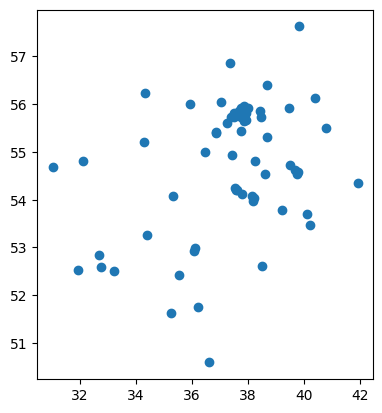

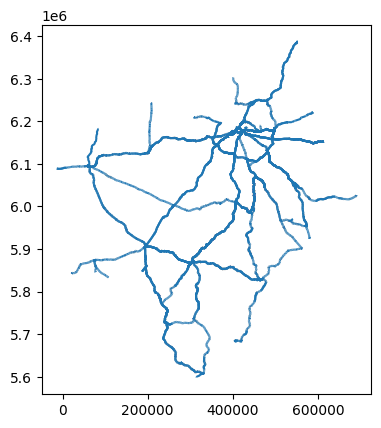

In [3]:
import matplotlib.pyplot as plt

shape2 = aggregated_data
shapefile.plot()
plt.show()

shape2.plot()
plt.show()


In [4]:
import geopandas as gpd

# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km']])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  
2   MULTILINESTRING ((420474.245 6171937.324, 4204...  122.1712

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [7]:
import geopandas as gpd
import networkx as nx



In [8]:
all_routes = aggregated_data


# Create an empty graph
G = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])


In [9]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        train_df.at[index, 'num_stations'] = 0

# Print updated train_df
print(train_df)



      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  
0              268.887101           2.0  
1             1166.548994           5.0  
2              314.678247           2.0  
3             2668.333561           7.0  
4              822.466978           4.0  
...

In [10]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [11]:
# Example: Iterate over train_df to find optimal paths
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        test_df.at[index, 'num_stations'] = 0

# Print updated train_df
print(test_df)

      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  
0              757.835709           4.0  
1                0.000000           0.0  
2              438.417927           4.0  
3              433.693874  

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=["index",'value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Define CatBoost parameters
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': "RMSE",
    'random_seed': 42
}

# Convert data to CatBoost Pool format
train_pool = Pool(data=X_train, label=y_train, cat_features = ['route_start',"route_end"])
val_pool = Pool(data=X_val, label=y_val, cat_features = ['route_start',"route_end"])

# Perform cross-validation
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  # Number of folds for cross-validation
                verbose=100,  # Print progress every 100 iterations
                plot=True)  # Plot training metrics

# Get best iteration
best_iteration = len(cv_results)  # Use the number of iterations where the best metric was achieved

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.9276287	test: 10.9938412	best: 10.9938412 (0)	total: 56.3ms	remaining: 56.2s
100:	learn: 2.0086952	test: 2.1682954	best: 2.1682954 (100)	total: 253ms	remaining: 2.25s
200:	learn: 1.6228640	test: 1.9966014	best: 1.9960461 (199)	total: 437ms	remaining: 1.74s
300:	learn: 1.3405188	test: 1.9416567	best: 1.9406946 (291)	total: 622ms	remaining: 1.44s
400:	learn: 1.1626342	test: 1.9208645	best: 1.9157972 (375)	total: 816ms	remaining: 1.22s
500:	learn: 1.0201753	test: 1.9194668	best: 1.9157972 (375)	total: 1.03s	remaining: 1.02s
600:	learn: 0.9016429	test: 1.9053853	best: 1.9027053 (592)	total: 1.22s	remaining: 808ms
700:	learn: 0.8028423	test: 1.8923059	best: 1.8923059 (700)	total: 1.41s	remaining: 599ms
800:	learn: 0.7303988	test: 1.8807424	best: 1.8805554 (799)	total: 1.59s	remaining: 396ms
900:	learn: 0.6673490	test: 1.8793452	best: 1.8756320 (851)	total: 1.79s	remaining: 197ms
999:	learn: 0.6080003	test: 1.8711413	best: 1.8702696 (983)	total: 2.01s	rema

In [14]:
# Initialize CatBoostRegressor with best parameters
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=6,
                               loss_function='RMSE',
                               random_seed=42)
train_pool = Pool(data=X, label=y, cat_features=['route_start',"route_end"])
best_model.fit(train_pool,verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3594934	total: 2.7ms	remaining: 2.7s
100:	learn: 1.8274016	total: 199ms	remaining: 1.77s
200:	learn: 1.5154516	total: 387ms	remaining: 1.54s
300:	learn: 1.3321589	total: 577ms	remaining: 1.34s
400:	learn: 1.1822998	total: 762ms	remaining: 1.14s
500:	learn: 1.0780558	total: 944ms	remaining: 940ms
600:	learn: 0.9876555	total: 1.14s	remaining: 754ms
700:	learn: 0.9063961	total: 1.32s	remaining: 565ms
800:	learn: 0.8352374	total: 1.51s	remaining: 377ms
900:	learn: 0.7749305	total: 1.7s	remaining: 187ms
999:	learn: 0.7267778	total: 1.89s	remaining: 0us


In [15]:
# Predict on test data
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")


RMSE: 1.23 hours
MAE: 0.88 hours


In [16]:
test_pool = Pool(data=test_df, cat_features=['route_start',"route_end"])

# Assuming 'test_df' has similar structure as 'train_df' without 'optimal_distance_km'
test_pred = best_model.predict(test_pool)

# Print or use 'test_pred' as needed for your application
print(test_pred)

[10.70916821 10.16831371 11.24417149 ... 13.14226435  9.6576427
 11.08942766]


In [17]:
test_df

,index,route_start,route_end,optimal_distance_km,num_stations
0,2623,Вязьма,Щёлково,757.835709,4.0
1,4413,Аэропорт,Лесок,0.000000,0.0
2,480,Узуново,Малоярославец,438.417927,4.0
3,4409,Серпухов,Лесок,433.693874,3.0
4,9286,Кунцево II,Петушки,716.954299,5.0
...,...,...,...,...,...
1514,1676,Елец,Перово,0.000000,0.0
1515,8047,Зелёный Бор,Вековка,454.405937,3.0
1516,37,Москва-Товарная-Смоленская,Курбакинская,703.990153,4.0
1517,1179,Смоленск-Сортировочный,Владимир,941.980834,4.0


In [18]:
train_df

,index,value,route_start,route_end,optimal_distance_km,num_stations
0,1198,4.150000,Кусково,Яничкино,268.887101,2.0
1,2983,14.300000,Вековка,Курск,1166.548994,5.0
2,3418,7.116667,Люблино-Сортировочное,Рязань-2,314.678247,2.0
3,1955,20.333333,Красное,Погар,2668.333561,7.0
4,1697,13.900000,Белгород,Елец,822.466978,4.0
...,...,...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск,0.000000,0.0
1515,1364,9.166667,Волоколамск,Вековка,639.926471,2.0
1516,1419,10.866667,Перово,Елец,0.000000,0.0
1517,1723,9.483333,Волоколамск,Узуново,589.934647,4.0


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-07-03 13:42:16.459159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 13:42:16.459367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 13:42:16.594498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
from sklearn.preprocessing import LabelEncoder

# Example data
data_train1 = train_df["route_start"]
data_train2 = train_df["route_end"]

encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoded_data1 = encoder1.fit_transform(data_train1)
encoded_data2 = encoder2.fit_transform(data_train2)


print(encoded_data1)
print(encoded_data2)



[19  7 25 ... 34  9 42]
[55 18 42 ... 12 52 34]


In [21]:
# Example data
data_test1 = test_df["route_start"]
data_test2 = test_df["route_end"]
encoded_test_data1 = encoder1.transform(data_test1)
encoded_test_data2 = encoder2.transform(data_test2)


print(encoded_test_data1)
print(encoded_test_data2)

[11  2 52 ... 28 46  2]
[54 20 26 ... 17  8  4]


In [22]:
train_df["route_start"] = encoded_data1
train_df["route_end"] = encoded_data2
test_df["route_start"] = encoded_test_data1
test_df["route_end"] = encoded_test_data1

In [23]:
train_df.dropna()

,index,value,route_start,route_end,optimal_distance_km,num_stations
0,1198,4.150000,19,55,268.887101,2.0
1,2983,14.300000,7,18,1166.548994,5.0
2,3418,7.116667,25,42,314.678247,2.0
3,1955,20.333333,15,37,2668.333561,7.0
4,1697,13.900000,5,12,822.466978,4.0
...,...,...,...,...,...,...
1514,2424,10.683333,24,9,0.000000,0.0
1515,1364,9.166667,9,7,639.926471,2.0
1516,1419,10.866667,34,12,0.000000,0.0
1517,1723,9.483333,9,52,589.934647,4.0


In [24]:
# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=["index",'value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [26]:
X_test_scaled

array([[ 1.21757331,  1.51603742,  2.16620932,  2.19019234],
       [ 1.21757331,  0.31003653,  0.21429895,  0.71536303],
       [-1.63515405,  0.79243688, -0.13068899,  0.22375325],
       ...,
       [-1.57445772,  1.57633746, -1.4144132 , -1.74268583],
       [-1.39236874, -1.43866477,  0.32782355,  0.71536303],
       [ 0.42852106, -1.0768645 , -0.65309174, -0.26785652]])

In [27]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.1), 
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)  # No activation function for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on test data
mse = model.evaluate(X_test_scaled, y_val)
print(f"Mean Squared Error on test data: {mse}")

# Make predictions
predictions = model.predict(X_test_scaled)
print("Predictions:")
print(predictions)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 119.7822 - val_loss: 68.6007
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.5283 - val_loss: 14.5301
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7238 - val_loss: 13.6538
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9205 - val_loss: 13.0978
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8637 - val_loss: 12.7749
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8298 - val_loss: 12.3177
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.6611 - val_loss: 12.0720
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.7420 - val_loss: 11.7922
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.4523 - val_loss: 11.5138
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7091 - val_loss: 11.3145
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5772 - val_loss: 11.0933
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [28]:
test_df = test_df.drop(columns = ["index"])

In [29]:
test = scaler.transform(test_df)
test

array([[-1.02819078, -1.01656445, -0.05490136,  0.22375325],
       [-1.57445772, -1.55926486, -1.4144132 , -1.74268583],
       [ 1.46035862,  1.45573737, -0.62791772,  0.22375325],
       ...,
       [ 0.00364678,  0.0085363 , -0.15149706,  0.22375325],
       [ 1.09618066,  1.0939371 ,  0.27544395,  0.22375325],
       [-1.57445772, -1.55926486, -1.4144132 , -1.74268583]])

In [30]:
predictions = model.predict(test)
print("Predictions:")
print(predictions)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predictions:
[[11.357541]
 [12.876586]
 [ 9.183049]
 ...
 [10.623906]
 [10.665214]
 [12.876586]]


In [31]:
predictions, test_pred

(array([[11.357541],
        [12.876586],
        [ 9.183049],
        ...,
        [10.623906],
        [10.665214],
        [12.876586]], dtype=float32),
 array([10.70916821, 10.16831371, 11.24417149, ..., 13.14226435,
         9.6576427 , 11.08942766]))

In [32]:
test_csv = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")
test_csv

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


In [33]:
test_csv["value_predict"] = predictions

In [34]:
test_csv.to_csv("dense_predict.csv")

In [35]:
test_csv["value_predict"] = test_pred

In [36]:
test_csv.to_csv("cb_predict.csv")

In [37]:
pred_ensemble = 0.4*predictions+0.6*test_pred
test_csv["value_predict"] = pred_ensemble
test_csv.to_csv("ensemble_predict.csv")